# An SQL & Python analysis of sells of a fictional record store

Let's analyze a fictional data set of a record store to check which adjustements have to be made in order to increase sells. We need to find out what our customers listen to and which customers we need to focus on.

Import necessary libraries: urllib (for getting the dataset), sqlite3, pandas, matplotlib, seaborn

In [73]:
import urllib.request
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Now fetch the dataset and check all table names. The dataset is available at GitHub

In [74]:
db_url = "https://www.timestored.com/data/sample/chinook.db"
urllib.request.urlretrieve(db_url, "fictional_music_store.db")
conn = sqlite3.connect('fictional_music_store.db')
cursor = conn.cursor()

def list_tables_from_db (cursor):
    cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table';")
    rows = cursor.fetchall()
    i = 1
    for row in rows:
      print(i,row[0])
      i +=1

music_store_tables = list_tables_from_db(cursor)

1 albums
2 sqlite_sequence
3 artists
4 customers
5 employees
6 genres
7 invoices
8 invoice_items
9 media_types
10 playlists
11 playlist_track
12 tracks
13 sqlite_stat1


Now lets analyze the best sold tracks in this music store. To make things easier we define shorter names for the table names: 
- tr for Track
- alb for Album
- art for Artist
- il for Invoice Line

We can use the shortcuts before we define them as long as they are in the same code.
To find out the best sold tracks we use SQL language in Python and store the ouput in a pandas DataFrame.

First we SELECT the columns we want to have in our final table: 

1. Artist: which is available in the table Artist or art, in the column 'name'
2. Total_Tracks_Sold: This is a newly defined column. We use the sum of the column Quantity in the Table InvoideLine or il which shows how many tracks are sold. 

The we type the table which we are working with which is il.

To get all the information we need, we join the tables tr, alb and art according to their primary keys:

We join the tables tr and il by using the column TrackID (containing primary key values) which is present in both tables.
Similarly, we join tables alb and tr according to the column AlbumID and tables art and alb according to ArtistID.
By using the GROUP BY command we get rid of duplication. We first group the data according to the artists name and then finally order them by the Total_Tracks_Sold values in a descending manner starting with the best sold track. In contrast to the GROUP BY command the ORDER BY command ignores duplicates.
the command LIMIT 10 limits the output to get the Top10 values.         





## Analyze Top10 best sold Artists

In [75]:
query = '''
SELECT art.Name AS Artist, SUM(ii.Quantity) AS Total_Tracks_Sold
FROM invoice_items ii
JOIN tracks tr ON ii.TrackId = tr.TrackId
JOIN albums alb ON tr.AlbumId = alb.AlbumId
JOIN artists art ON alb.ArtistId = art.ArtistId
GROUP BY art.Name
ORDER BY Total_Tracks_Sold DESC
LIMIT 10;
'''

top_artists = pd.read_sql_query(query,conn)
print(top_artists)

                    Artist  Total_Tracks_Sold
0              Iron Maiden                140
1                       U2                107
2                Metallica                 91
3             Led Zeppelin                 87
4  Os Paralamas Do Sucesso                 45
5              Deep Purple                 44
6            Faith No More                 42
7                     Lost                 41
8             Eric Clapton                 40
9                   R.E.M.                 39


We can also show these results visually.

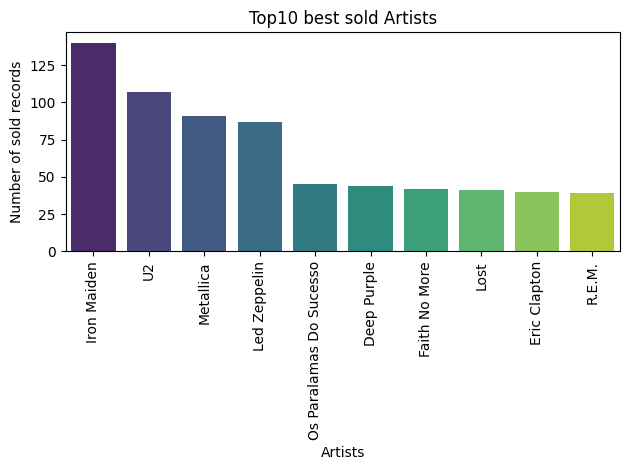

In [76]:
sns.barplot(x=top_artists['Artist'], y=top_artists['Total_Tracks_Sold'], hue = top_artists['Artist'], legend = False, palette = "viridis")
plt.xlabel("Artists")
plt.ylabel("Number of sold records")
plt.title("Top10 best sold Artists")
plt.xticks(rotation=90)
figsize=(16, 6)
plt.tight_layout()
plt.show()

## Analyze Top10 genres

Similar as before we create an SQL query. This time we select the genre and the newly defined column 'mist_sold_genres' which is the sum of the quantity column of the il table.
Now we need to join the tables il containing the sold tracks with the table tr which contains the tracks and the genres and finally join the tr and the genre table ge.

In [77]:
query2= '''
SELECT ge.Name as Genre, SUM(ii.Quantity) AS most_sold_genres
FROM invoice_items ii
JOIN tracks tr ON ii.TrackId = tr.TrackId
JOIN genres ge ON tr.GenreId = ge.GenreId
GROUP BY ge.Name
ORDER BY most_sold_genres DESC
LIMIT 10;'''

top_genres = pd.read_sql_query(query2,conn)
print (top_genres)



                Genre  most_sold_genres
0                Rock               835
1               Latin               386
2               Metal               264
3  Alternative & Punk               244
4                Jazz                80
5               Blues                61
6            TV Shows                47
7            R&B/Soul                41
8           Classical                41
9              Reggae                30


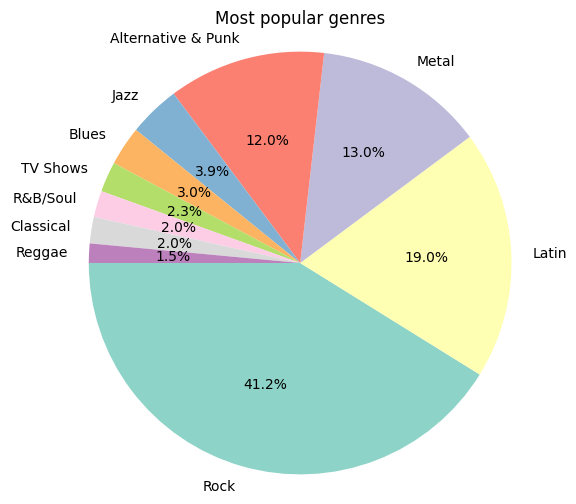

In [78]:
plt.figure(figsize=(6,6))
plt.pie(top_genres['most_sold_genres'], labels =top_genres['Genre'],autopct='%1.1f%%', startangle=180, colors=sns.color_palette('Set3'))
plt.axis('equal')
plt.title('Most popular genres')
plt.show()

## Analyzing the countries which have the highest invoices

Here, we can use only one table containing all the information which is the table 'Invoice'.
We select the country names and thn define a new column calculating the sum of all invoices of each country.
By using GROUP BY we can elimitae duplications and finally order them by their total invoices starting with the highest.

           country  sum_of_invoices
0              USA           523.06
1           Canada           303.96
2           France           195.10
3           Brazil           190.10
4          Germany           156.48
5   United Kingdom           112.86
6   Czech Republic            90.24
7         Portugal            77.24
8            India            75.26
9            Chile            46.62
10         Ireland            45.62
11         Hungary            45.62
12         Austria            42.62
13         Finland            41.62
14     Netherlands            40.62
15          Norway            39.62
16          Sweden            38.62
17           Spain            37.62
18          Poland            37.62
19           Italy            37.62
20         Denmark            37.62
21         Belgium            37.62
22       Australia            37.62
23       Argentina            37.62


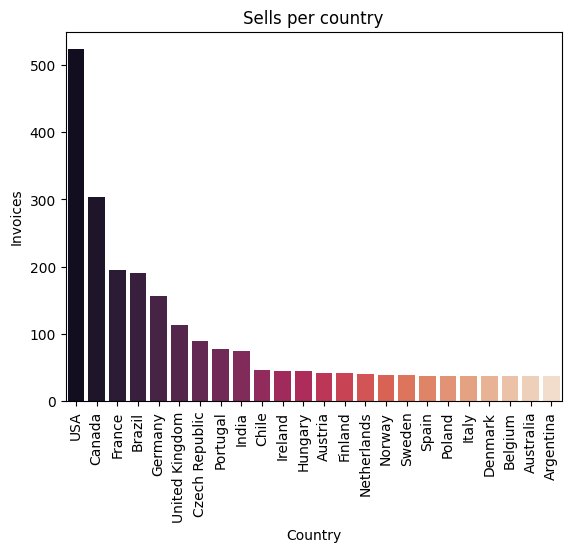

In [79]:
query3= '''
SELECT inv.BillingCountry AS country, SUM(inv.Total) AS sum_of_invoices
FROM Invoices inv
GROUP BY inv.BillingCountry
ORDER BY sum_of_invoices DESC;'''

invoice_per_country = pd.read_sql_query(query3,conn)
print(invoice_per_country)

sns.barplot(x= invoice_per_country['country'], y = invoice_per_country['sum_of_invoices'], hue = invoice_per_country['country'], legend = False, palette = "rocket")
plt.xlabel('Country')
plt.ylabel('Invoices')
plt.title('Sells per country')
plt.xticks(rotation=90)
plt.show()

Since the USA is our top customer lets check what they want to hear so we can arrange our records accordingly and hopefully increasing our sales.

                Genre  Total_Invoices
0                Rock         1526.14
1               Latin          754.67
2               Metal          554.45
3  Alternative & Punk          415.92
4                Jazz          202.95
5            TV Shows          191.70
6               Drama          143.16
7               Blues          126.72
8              Comedy           90.44
9           Classical           87.20


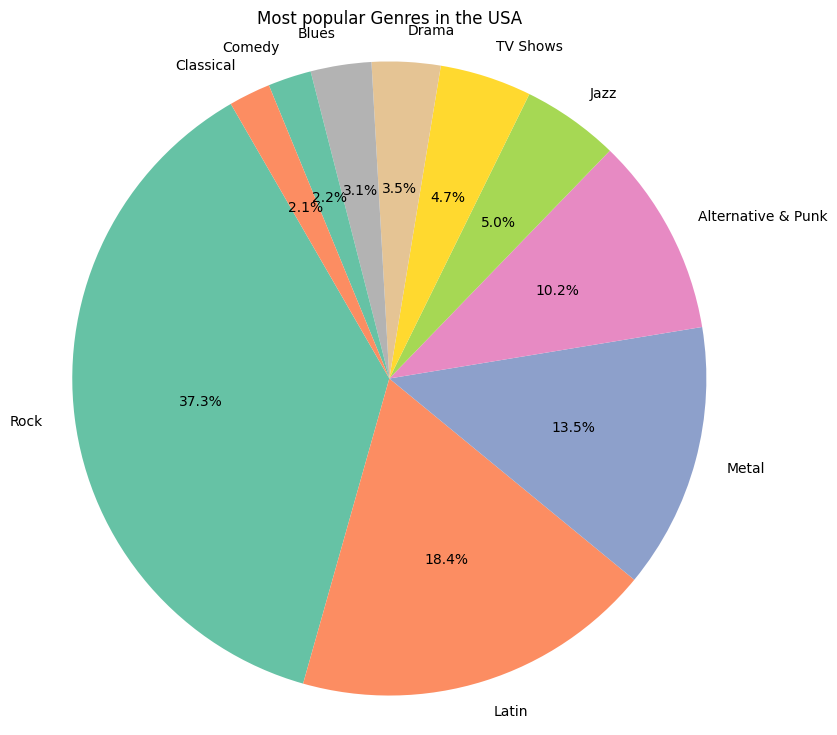

In [80]:
query5 ='''
SELECT ge.name AS Genre, SUM(inv.Total) AS Total_Invoices
FROM invoices inv
JOIN invoice_items ii ON inv.InvoiceId = ii.InvoiceId
JOIN tracks tr ON ii.TrackId = tr.TrackId
JOIN genres ge ON tr.GenreId = ge.GenreId
WHERE BillingCountry = 'USA'
GROUP BY ge.GenreId
ORDER BY Total_Invoices DESC
LIMIT 10;
'''

USA_most_popular_genres = pd.read_sql_query(query5,conn)
print (USA_most_popular_genres)


plt.figure(figsize=(9,9))
plt.pie(USA_most_popular_genres['Total_Invoices'], labels = USA_most_popular_genres['Genre'],autopct='%1.1f%%', startangle=120, colors=sns.color_palette('Set2'))
plt.axis('equal')
plt.title('Most popular Genres in the USA')
plt.show()



## Conclusion

The USA is our most poular customer so we adapt our records according to their preferences. The best sold genres in the USA are Rock, Latin and Metal therefore it makes sense to have a higher amount of records of this genre in our store.